# Data loading
We just have to load the data from the excel file.

In [5]:
import pandas as pd
from dotenv import load_dotenv
import os

load_dotenv()

df_o = pd.read_excel('corpus/interaction-corpus.xlsx')

df_o.head()

,CODE ID,Turn,Participant,Text,Version,Experiment,VIP,Token count,Errors_GOLD
0,ctyHWUgv9B_kHA6DNcrgMxadmJZJ1sHa,1,U,hi,[2023-05-28],[Si],no,1,NaN
1,ctyHWUgv9B_kHA6DNcrgMxadmJZJ1sHa,2,S,"I don't know, try asking something like, ""What...",[2023-05-28],[Si],no,13,Topic change
2,ctyHWUgv9B_kHA6DNcrgMxadmJZJ1sHa,3,U,describe the automaton,[2023-05-28],[Si],no,3,Ignoring question/feedback
3,ctyHWUgv9B_kHA6DNcrgMxadmJZJ1sHa,4,S,It is an automaton which accepts zero or more ...,[2023-05-28],[Si],no,86,NaN
4,ctyHWUgv9B_kHA6DNcrgMxadmJZJ1sHa,5,U,There is a transition between q2 and q0,[2023-05-28],[Si],no,8,NaN


# Filtering
We only need the rows that represent the interaction from the user.

In [6]:
# filter only the rows that have "Participant" as 'U'
df = df_o[df_o['Participant'] == 'U']
df = df[['Text']]
df = df.drop_duplicates()
df = df[df['Text'].apply(lambda x: isinstance(x, str))]
df['Text'] = df['Text'].str.strip()  # Remove trailing whitespace
texts = df['Text'].dropna()

df.to_json("./filtered_data.json", orient='records', lines=False, indent=2)
df.to_csv("./filtered_data.csv")

# print the first 5 rows
df

,Text
0,hi
2,describe the automaton
4,There is a transition between q2 and q0
6,There is a transition between q5 and q7
8,Describe it please
...,...
716,what is its optimal spatial representation of ...
718,The automaton accepts a language allowing word...
720,It is possible to find a repetitive pattern in...
722,Si c e un solo arco che inizia da ogni stato I...


In [15]:
import labelbox as lbx

api_key = os.getenv("LABELBOX_KEY")
client = lbx.Client(api_key)

dataset = client.get_dataset(dataset_id="cm2w33x47004z0743gu4fipjo")

row: str
assets = []
for idx, row in enumerate(list(df["Text"])):
    # if idx > 10: break
    assets.append({
        "row_data": row,
        "media_type": "TEXT"
    })

task = dataset.create_data_rows(assets)
task.wait_till_done()

print(task.errors)


None


# Clustering
Once we have all the interactions, we can start preparing the clusterer.
The first step is to convert the text data into numerical data using the TF-IDF vectorization.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display

# Convert text data to numerical data using TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(texts)

Then we can use the elbow method to find the optimal number of clusters.
The elbow method consists of plotting the inertia values (sum of squared distances of samples to their closest cluster center) for different numbers of clusters and finding the "elbow" point where the inertia starts decreasing more slowly.

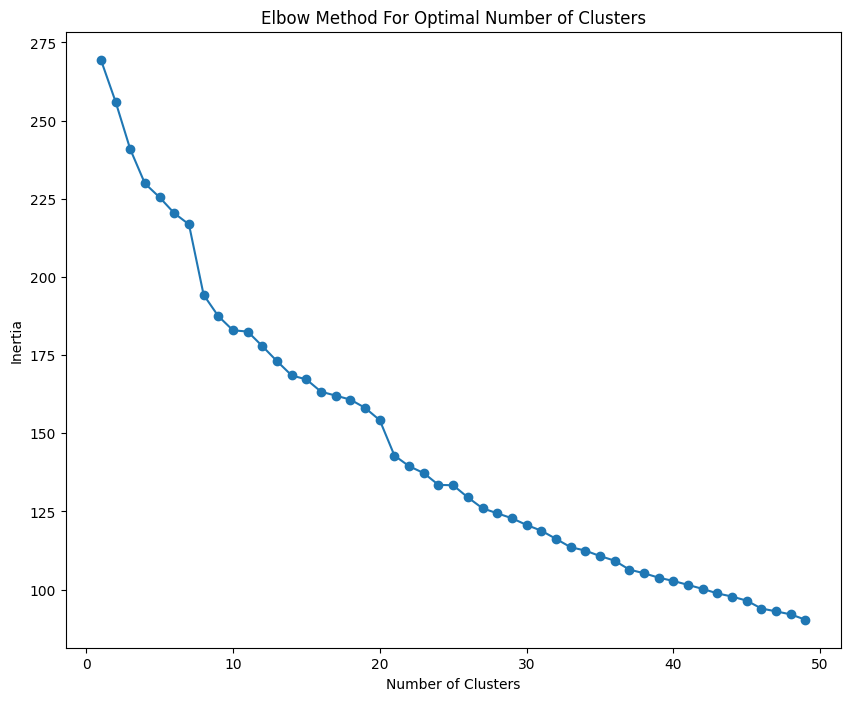

In [8]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Range of clusters to try
cluster_range = range(1, 50)
inertia = []

# Compute inertia for each number of clusters
for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the inertia values
plt.figure(figsize=(10, 8))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

Once we've seen the plot, we can use the KneeLocator to find the elbow point automatically.

In [9]:
from kneed import KneeLocator

# Use KneeLocator to find the elbow point
kneedle = KneeLocator(cluster_range, inertia, curve='convex', direction='decreasing')
optimal_clusters = kneedle.elbow

print(f'The optimal number of clusters is: {optimal_clusters}')

The optimal number of clusters is: 16


Finally we can apply the KMeans clustering algorithm to the data and assign the cluster labels to the original text data.
These clusters will help us to group similar interactions together to then tag them with the corresponding intent.

In [10]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(X)

# Assign cluster labels to the original text data
df['Cluster'] = kmeans.labels_

# Display the first 5 elements of each cluster
for i in range(optimal_clusters):
    print(f'Cluster {i}:')
    display(df[df['Cluster'] == i])

Cluster 0:


,Text,Cluster
242,what are the final states,0
244,how many final states there are,0
250,which are the final states,0
254,How many final states are there,0
540,what are the final states,0
542,final states,0


Cluster 1:


,Text,Cluster
20,What is q1,1
54,Is there an arc from q0 to q1,1
96,Is there an arc from q1 to q2,1
108,Is there an arc from q0,1
110,Is there an arc from q1,1
112,Is there an arc from q2,1
310,is there an arc between q0 and q1,1
344,Is there an arc between q0 and q1,1
346,Is there an arc between q1 and q2,1
390,is there an arc from q0 to q1,1


Cluster 2:


,Text,Cluster
12,there is a particular pattern among them,2
138,Is there a particular pattern,2
206,Is there a particular pattern among the arcs,2
234,is there a particulare pattern,2
304,Is there a pattern among the arcs,2
432,is there a particulare pattern among automata ...,2
506,pattern,2
558,Is there a pattern among the transitions,2
592,pattern among arcs,2
638,what is a pattern,2


Cluster 3:


,Text,Cluster
10,How many transitions does the automaton contain,3
218,How many transitions does the automata have,3
222,What transitions does the automaton have,3


Cluster 4:


,Text,Cluster
16,What are the transitions,4
60,Which are the transitions from q1,4
62,Which are the transitions from q2,4
66,Which are the transitions from q4,4
80,what are the transitions from q4,4
136,How many transitions are there,4
190,can you describe the transitions,4
204,How many transitions are there in the automaton,4
212,Please describe the transitions,4
220,Show me the transitions of the automaton,4


Cluster 5:


,Text,Cluster
2,describe the automaton,5
30,Describe the automaton,5
88,can you describe me the automaton,5
146,Please describe the automaton,5
182,can you describe the automaton,5
196,Can you describe the automaton,5
348,describe me the automaton,5
374,what is an automaton,5
464,where is automaton 2,5
474,What are automaton,5


Cluster 6:


,Text,Cluster
52,Give me a list of the arcs,6
56,What is the shape of the arcs,6
232,how many arcs there are,6
236,are there arcs between q2 and q0,6
238,are there arcs from q4,6
430,how many arcs are there in the automata,6
570,arcs between q4 and q0,6
572,arcs from q4,6
590,how many arcs,6
606,what arcs are marked with 0,6


Cluster 7:


,Text,Cluster
0,hi,7
4,There is a transition between q2 and q0,7
6,There is a transition between q5 and q7,7
8,Describe it please,7
14,What is the alphabet,7
...,...,...
714,Is there a transition from q0 to q5,7
716,what is its optimal spatial representation of ...,7
718,The automaton accepts a language allowing word...,7
720,It is possible to find a repetitive pattern in...,7


Cluster 8:


,Text,Cluster
36,If q2 is the final state the language accepted...,8
132,What is the accepted language,8
202,Is 11100 part of the accepted language,8
272,If q2 were the final state the language accept...,8
382,what is the language accepted by the automaton,8
426,If q0 were the final state the language accept...,8
656,what is the accepted language,8
724,If q0 were the final state the language accept...,8


Cluster 9:


,Text,Cluster
102,Is there an arc from q3 to q4,9
104,Is there an arc from q4 to q0,9
106,Is there an arc from q4,9
700,which arc from q4,9


Cluster 10:


,Text,Cluster
18,What are the states,10
22,how many states and edges,10
48,Does it have 5 states then,10
50,How many states are there,10
72,How many states do you have,10
74,how are your states linked together,10
98,What are the states connected to q0,10
116,How many states does the automaton have,10
144,How many states,10
178,how many states,10


Cluster 11:


,Text,Cluster
58,Is there an arc from q0 to q2 q3 or q4,11
64,Which are the transitions from q3,11
100,Is there an arc from q2 to q3,11
114,Is there an arc from q3,11
588,label from q3 to q4,11
598,transition from q3,11
662,q2,11
664,q2 to q3,11
666,q3 to q2,11
668,q3 to q4,11


Cluster 12:


,Text,Cluster
46,Which is the initial state,12
366,What is the initial state,12
376,what is the initial stage of the automaton,12
380,what is the initial state of the automaton,12
492,initial state,12
578,which is initial state,12


Cluster 13:


,Text,Cluster
214,Is q0 the final state,13
246,is q0 a final state,13
248,is q4 a final state,13
252,which is the final state,13
280,What is the final state of an automaton,13
290,What is the final state,13
482,Which one si the final state,13
580,which is final state,13
582,final state,13
710,What is the final state,13


Cluster 14:


,Text,Cluster
76,is q0 linked to q0,14
78,is q1 linked to q4,14
86,is q4 linked to q0,14
660,q0,14
670,q4 to q0,14
672,q0 to q4,14


Cluster 15:


,Text,Cluster
120,What transitions enter and exit q0,15
122,What transitions enter and exit q1,15
124,What transitions enter and exit q2,15
126,What transitions enter and exit q4,15
128,What transitions enter and exit q3,15


# Topic Modeling

In [11]:
# Step 1: Preprocess the text data
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import nltk

nltk.download('wordnet')


def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # if token not in STOPWORDS and len(token) > 3:
        if token not in STOPWORDS:
            result.append(WordNetLemmatizer().lemmatize(token, pos='v'))
    return result


df['Processed_Text'] = df['Text'].map(preprocess)

df[['Text', 'Processed_Text']]

[nltk_data] Downloading package wordnet to /home/stefa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Text,Processed_Text
0,hi,[hi]
2,describe the automaton,[automaton]
4,There is a transition between q2 and q0,[transition]
6,There is a transition between q5 and q7,[transition]
8,Describe it please,[]
...,...,...
716,what is its optimal spatial representation of ...,"[optimal, spatial, representation, automaton]"
718,The automaton accepts a language allowing word...,"[automaton, accept, language, allow, word, odd..."
720,It is possible to find a repetitive pattern in...,"[possible, repetitive, pattern, transition]"
722,Si c e un solo arco che inizia da ogni stato I...,"[si, solo, arco, che, inizia, da, ogni, stato,..."


In [12]:

# Step 2: Create a dictionary and corpus
dictionary = gensim.corpora.Dictionary(df['Processed_Text'])
corpus = [dictionary.doc2bow(text) for text in df['Processed_Text']]

# Step 3: Apply LDA
lda_model = gensim.models.LdaModel(corpus, num_topics=optimal_clusters, id2word=dictionary, passes=15)


# Step 4: Assign topics to clusters
def get_dominant_topic(text):
    bow = dictionary.doc2bow(text)
    topics = sorted(lda_model[bow], key=lambda x: x[1], reverse=True)
    return topics[0][0]


df['Dominant_Topic'] = df['Processed_Text'].map(get_dominant_topic)

# Display the dominant topic for each cluster
for i in range(optimal_clusters):
    print(f'Cluster {i}:')
    display(df[df['Cluster'] == i][['Text', 'Dominant_Topic']])

Cluster 0:


,Text,Dominant_Topic
242,what are the final states,13
244,how many final states there are,13
250,which are the final states,13
254,How many final states are there,13
540,what are the final states,13
542,final states,13


Cluster 1:


,Text,Dominant_Topic
20,What is q1,0
54,Is there an arc from q0 to q1,10
96,Is there an arc from q1 to q2,10
108,Is there an arc from q0,10
110,Is there an arc from q1,10
112,Is there an arc from q2,10
310,is there an arc between q0 and q1,10
344,Is there an arc between q0 and q1,10
346,Is there an arc between q1 and q2,10
390,is there an arc from q0 to q1,10


Cluster 2:


,Text,Dominant_Topic
12,there is a particular pattern among them,15
138,Is there a particular pattern,15
206,Is there a particular pattern among the arcs,15
234,is there a particulare pattern,15
304,Is there a pattern among the arcs,15
432,is there a particulare pattern among automata ...,10
506,pattern,15
558,Is there a pattern among the transitions,8
592,pattern among arcs,15
638,what is a pattern,15


Cluster 3:


,Text,Dominant_Topic
10,How many transitions does the automaton contain,6
218,How many transitions does the automata have,8
222,What transitions does the automaton have,6


Cluster 4:


,Text,Dominant_Topic
16,What are the transitions,8
60,Which are the transitions from q1,8
62,Which are the transitions from q2,8
66,Which are the transitions from q4,8
80,what are the transitions from q4,8
136,How many transitions are there,8
190,can you describe the transitions,8
204,How many transitions are there in the automaton,6
212,Please describe the transitions,8
220,Show me the transitions of the automaton,6


Cluster 5:


,Text,Dominant_Topic
2,describe the automaton,6
30,Describe the automaton,6
88,can you describe me the automaton,6
146,Please describe the automaton,6
182,can you describe the automaton,6
196,Can you describe the automaton,6
348,describe me the automaton,6
374,what is an automaton,6
464,where is automaton 2,6
474,What are automaton,6


Cluster 6:


,Text,Dominant_Topic
52,Give me a list of the arcs,10
56,What is the shape of the arcs,10
232,how many arcs there are,10
236,are there arcs between q2 and q0,10
238,are there arcs from q4,10
430,how many arcs are there in the automata,10
570,arcs between q4 and q0,10
572,arcs from q4,10
590,how many arcs,10
606,what arcs are marked with 0,10


Cluster 7:


,Text,Dominant_Topic
0,hi,14
4,There is a transition between q2 and q0,8
6,There is a transition between q5 and q7,8
8,Describe it please,0
14,What is the alphabet,12
...,...,...
714,Is there a transition from q0 to q5,8
716,what is its optimal spatial representation of ...,2
718,The automaton accepts a language allowing word...,7
720,It is possible to find a repetitive pattern in...,1


Cluster 8:


,Text,Dominant_Topic
36,If q2 is the final state the language accepted...,7
132,What is the accepted language,7
202,Is 11100 part of the accepted language,7
272,If q2 were the final state the language accept...,7
382,what is the language accepted by the automaton,7
426,If q0 were the final state the language accept...,7
656,what is the accepted language,7
724,If q0 were the final state the language accept...,7


Cluster 9:


,Text,Dominant_Topic
102,Is there an arc from q3 to q4,10
104,Is there an arc from q4 to q0,10
106,Is there an arc from q4,10
700,which arc from q4,10


Cluster 10:


,Text,Dominant_Topic
18,What are the states,13
22,how many states and edges,13
48,Does it have 5 states then,13
50,How many states are there,13
72,How many states do you have,13
74,how are your states linked together,13
98,What are the states connected to q0,3
116,How many states does the automaton have,13
144,How many states,13
178,how many states,13


Cluster 11:


,Text,Dominant_Topic
58,Is there an arc from q0 to q2 q3 or q4,10
64,Which are the transitions from q3,8
100,Is there an arc from q2 to q3,10
114,Is there an arc from q3,10
588,label from q3 to q4,12
598,transition from q3,8
662,q2,0
664,q2 to q3,0
666,q3 to q2,0
668,q3 to q4,0


Cluster 12:


,Text,Dominant_Topic
46,Which is the initial state,5
366,What is the initial state,5
376,what is the initial stage of the automaton,5
380,what is the initial state of the automaton,5
492,initial state,5
578,which is initial state,5


Cluster 13:


,Text,Dominant_Topic
214,Is q0 the final state,13
246,is q0 a final state,13
248,is q4 a final state,13
252,which is the final state,13
280,What is the final state of an automaton,13
290,What is the final state,13
482,Which one si the final state,13
580,which is final state,13
582,final state,13
710,What is the final state,13


Cluster 14:


,Text,Dominant_Topic
76,is q0 linked to q0,13
78,is q1 linked to q4,13
86,is q4 linked to q0,13
660,q0,0
670,q4 to q0,0
672,q0 to q4,0


Cluster 15:


,Text,Dominant_Topic
120,What transitions enter and exit q0,14
122,What transitions enter and exit q1,14
124,What transitions enter and exit q2,14
126,What transitions enter and exit q4,14
128,What transitions enter and exit q3,14


In [13]:
df

,Text,Cluster,Processed_Text,Dominant_Topic
0,hi,7,[hi],14
2,describe the automaton,5,[automaton],6
4,There is a transition between q2 and q0,7,[transition],8
6,There is a transition between q5 and q7,7,[transition],8
8,Describe it please,7,[],0
...,...,...,...,...
716,what is its optimal spatial representation of ...,7,"[optimal, spatial, representation, automaton]",2
718,The automaton accepts a language allowing word...,7,"[automaton, accept, language, allow, word, odd...",7
720,It is possible to find a repetitive pattern in...,7,"[possible, repetitive, pattern, transition]",1
722,Si c e un solo arco che inizia da ogni stato I...,7,"[si, solo, arco, che, inizia, da, ogni, stato,...",0
